In [67]:
import numpy as np  # type: ignore
from matplotlib import pyplot as plt  # type: ignore

---

### Functions for each of the parameters: 

Half step velocity: $u_{i}^{n+\frac{1}{2}}$

In [68]:
def next_half_u(n, u, a, dt):
    half_u = np.zeros(n)
    for i in range(n):
        half_u[i] = u[i] + 0.5 * dt * a[i]
    return half_u

Next step distance: $x_{i}^{n+1}$

In [69]:
def next_x(n, x, half_u, dt):
    new_x = np.zeros(n)
    for i in range(n):
        new_x[i] = x[i] + dt * half_u[i]
    return new_x

Next step volume: $V_{i-\frac{1}{2}}^{n+1}$

In [70]:
def next_v(new_x):
    new_v = np.diff(new_x)
    return new_v

Next step density: $\rho_{i-\frac{1}{2}}^{n+1}$

In [71]:
def next_rho(n, m, new_v):
    new_rho = np.zeros(n-1)
    for i in range(n-1):
        new_rho[i] = m[i] / new_v[i]
    return new_rho

Artificial viscosity q:

In [72]:
def calculate_q(half_u, new_rho):
    n = len(half_u)
    q = np.zeros(n - 1)
    for i in range(1, n):
        if half_u[i] < half_u[i-1]:
            q[i-1] = 3 * new_rho[i-1] * \
                ((half_u[i-1] - half_u[i]) ** 2)
        else:
            q[i-1] = 0
    return q

Next step internal energy: $e_{i-\frac{1}{2}}^{n+1}$

In [73]:
def next_e(n, e, m, new_v, V, p, q_new, gamma, new_rho):
    new_e = np.zeros(n)
    for i in range(n-1):
        new_e[i] = (
            e[i] - 0.5 * (1/m[i]) * (new_v[i] - V[i]) * (p[i])
        ) / (
            1 + 0.5 * (1/m[i]) * (new_v[i] - V[i]) * new_rho[i] * (gamma - 1)
        )
    return new_e

Next step pressure: $p_{i-\frac{1}{2}}^{n+1}$

In [74]:
def next_p(n, new_e, new_rho, gamma):
    new_p = np.zeros(n-1)
    for i in range(n-1):
        new_p[i] = (gamma-1) * new_rho[i] * new_e[i]    # p_eos
    return new_p

Next step acceleration: $a_{i}^{n+1}$

In [75]:
def next_a(n, new_p, m):
    new_a = np.zeros(n)
    for i in range(1, n-1):
        new_a[i] = (-2) * (new_p[i] - new_p[i-1]) / (m[i] + m[i-1])
    return new_a

End of step velocity: $u_{i}^{n+1}$

In [76]:
def next_u(n, half_u, new_a, dt):
    new_u = np.zeros(n)
    for i in range(n):
        new_u[i] = half_u[i] + (dt/2) * new_a[i]
    return new_u

---

Function to make the step and update all the values:

In [77]:
def make_step(n, x, u, rho, v, e, p, a, m, gamma):

    new_x = np.zeros_like(x)
    new_u = np.zeros_like(u)
    half_u = np.zeros_like(u)
    new_rho = np.zeros_like(rho)
    new_v = np.zeros_like(v)
    new_e = np.zeros_like(e)
    new_p = np.zeros_like(p)
    new_a = np.zeros_like(a)

    # Courant condition: dt = min(0.2*dx/c) where c = sqrt(gamma*p/rho)
    dt = np.min(0.2 * np.diff(x) / (np.sqrt(gamma * p/rho)))

    while True:
        half_u = next_half_u(n, u, a, dt)
        new_x = next_x(n, x, half_u, dt)
        new_v = next_v(new_x)
        new_rho = next_rho(n, m, new_v)

        # check that rho changes no more than 5%
        diff = np.max(np.abs(new_rho - rho) / np.abs(rho))
        if diff > 0.05:
            dt = 0.5 * dt
        else:
            break

    q_new = calculate_q(half_u, new_rho)
    new_e = next_e(n, e, m, new_v, v, p, q_new, gamma, new_rho)
    new_p = next_p(n, new_e, new_rho, gamma) + \
        q_new    # add q as seen in class
    new_a = next_a(n, new_p, m)
    new_u = next_u(n, half_u, new_a, dt)

    return new_x, new_u, new_rho, new_v, new_e, new_p, new_a, dt

Helper function for calculating the fraction of energy non-conservation:  

In [78]:
def compute_total_energy(u, e, m):
    min_length = min(len(u), len(e), len(m))
    u_trimmed = u[:min_length]
    e_trimmed = e[:min_length]
    m_trimmed = m[:min_length]
    kinetic_energy = 0.5 * np.sum(m_trimmed * u_trimmed**2)
    internal_energy = np.sum(e_trimmed * m_trimmed)
    return kinetic_energy + internal_energy

Function for describing full system in the given period of time and with given initial conditions: 

In [79]:
def describe_full_system(n, x, u, rho, v, e, p, a, m, gamma, t_max, ax, color, label):
    time = 0
    flag = False
    start_total_energy = compute_total_energy(u, e, m)
    while time < t_max:
        x, u, rho, v, e, p, a, dt = make_step(
            n, x, u, rho, v, e, p, a, m, gamma)
        time += dt
        if time > 2 and not flag:
            flag = True
            rho_2_vals = rho.copy()
            x_2_vals = x.copy()
    end_total_energy = compute_total_energy(u, e, m)
    energy_fraction = (end_total_energy -
                       start_total_energy) / start_total_energy
    rho_vals = rho.copy()
    x_vals = x.copy()
    x_vals = x_vals[:-1]
    ax.plot(x_vals, rho_vals, color=color, label=label)
    ax.grid(True)

    # speed calculation - the indices I chose manually from the graphs
    if (t_max == 2.5):
        # shock wave
        ind1 = np.argmin(abs(rho_vals - 0.23))
        ind2 = np.argmin(abs(rho_2_vals - 0.23))
        xl1 = x_vals[ind1]
        xl2 = x_2_vals[ind2]
        speed1 = (xl1 - xl2)/0.5
        print(f"For n={n}, shockwave propagation speed is {speed1:.2f} [cm/s]")
        # contact surface wave
        ind3 = np.argsort(abs(rho_vals - 0.23))[0]
        ind4 = np.argsort(abs(rho_vals - 0.23))[0]
        xl3 = x_vals[ind3]
        xl4 = x_2_vals[ind4]
        speed2 = (xl3 - xl4)/0.5
        print(
            f"For n={n}, contact surface propagation speed is {speed2:.2f} [cm/s]")
        # refraction wave
        dist5 = abs(rho_vals - 1)
        ind5 = np.where(dist5 > 1e-3)[0][0]
        dist6 = abs(rho_2_vals - 1)
        ind6 = np.where(dist6 > 1e-3)[0][0]
        xl5 = x_vals[ind5]
        xl6 = x_2_vals[ind6]
        speed3 = (xl5 - xl6)/0.5
        print(
            f"For n={n}, refraction wave propagation speed is {speed3:.2f} [cm/s]")
        print("\n")

    return float(energy_fraction)

---

Now, lets test. We will give the initial conditions as described in the exercise, 4 different resolutions: 34,100,334 and 1000, and two different times: 2.5 sec and 2 sec for calcualting the speed of propagation: 

For n=34, shockwave propagation speed is 0.87 [cm/s]
For n=34, contact surface propagation speed is 0.87 [cm/s]
For n=34, refraction wave propagation speed is -1.94 [cm/s]


For n=100, shockwave propagation speed is 1.65 [cm/s]
For n=100, contact surface propagation speed is 0.32 [cm/s]
For n=100, refraction wave propagation speed is -1.29 [cm/s]


For n=334, shockwave propagation speed is 1.73 [cm/s]
For n=334, contact surface propagation speed is 0.11 [cm/s]
For n=334, refraction wave propagation speed is -1.15 [cm/s]


For n=1000, shockwave propagation speed is 1.73 [cm/s]
For n=1000, contact surface propagation speed is 0.03 [cm/s]
For n=1000, refraction wave propagation speed is -1.19 [cm/s]




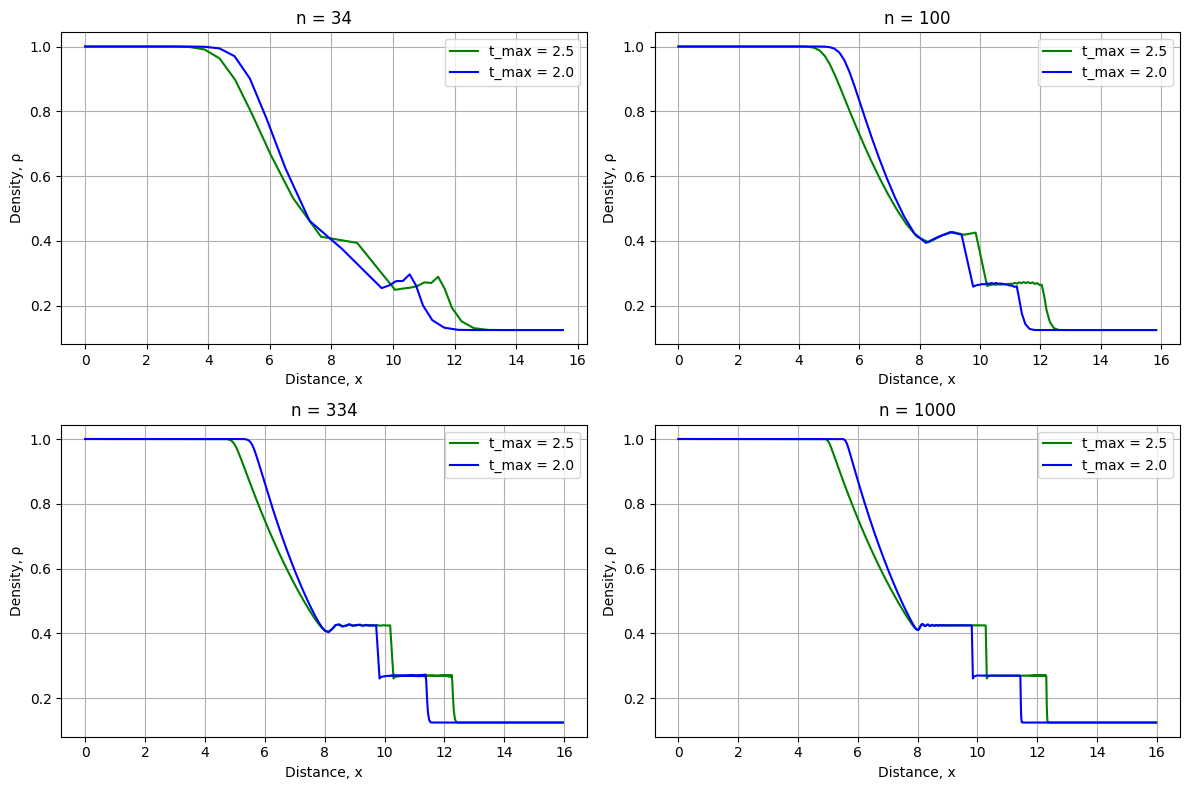

Resolution | Energy Fraction (t_max = 2.5) | Energy Fraction (t_max = 2.0)
-------------------------------------------------------------
34         | -0.006794227712091676        | -0.006347772201626349       
100        | -0.003472818500250769        | -0.00317197290254052        
334        | -0.002156933613093831        | -0.001829349965591165       
1000       | -0.0017979383197996364       | -0.0014737565169585666      


In [80]:
num_points = [34, 100, 334, 1000]
gamma = 1.4
energy_fractions = []

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, n in enumerate(num_points):
    x_pos = np.linspace(0, 16, n)
    v_array = np.diff(x_pos)
    u_array = np.zeros(n)
    a_array = np.zeros(n)
    rho_array = np.zeros(n-1)
    for j in range(len(rho_array)):
        if j < len(rho_array) // 2:
            rho_array[j] = 1
        else:
            rho_array[j] = 0.125
    m = rho_array * v_array
    p = np.zeros(n-1)
    for j in range(len(p)):
        if j < len(p) // 2:
            p[j] = 1
        else:
            p[j] = 0.1
    e = p / ((gamma - 1) * rho_array)

    ax = axs[i // 2, i % 2]
    ef_25 = describe_full_system(n, x_pos, u_array, rho_array, v_array,
                                 e, p, a_array, m, gamma, 2.5, ax, 'green', 't_max = 2.5')

    ef_20 = describe_full_system(n, x_pos, u_array, rho_array, v_array,
                                 e, p, a_array, m, gamma, 2.0, ax, 'blue', 't_max = 2.0')

    energy_fractions.append((n, ef_25, ef_20))
    ax.set_title(f'n = {n}')
    ax.set_xlabel('Distance, x')
    ax.set_ylabel('Density, ρ')
    ax.legend()

plt.tight_layout()
plt.show()

print("Resolution | Energy Fraction (t_max = 2.5) | Energy Fraction (t_max = 2.0)")
print("-------------------------------------------------------------")
for n, ef_25, ef_20 in energy_fractions:
    print(f"{n:<10} | {ef_25:<28} | {ef_20:<28}")

##### Explanation: 
We can see that the more samples (points) we take - we get less gradual and more "step-like" graph and less change in the fraction of energy non-conservation. We can see that the values are megative, meaning that the total energy is slightly decreasing, and the more samples there are - the less it changes. It can be caused by a number of factors, like:
 
*Numerical Dissipation: Numerical methods can introduce small dissipative effects over time, leading to a gradual loss of energy.

*Algorithmic Accuracy: The accuracy of the numerical method used in search_full_system and make_step could influence how closely the total energy is conserved.

*Simulation Parameters: The choice of time step ($dt$), spatial resolution ($n$), and the specific numerical scheme employed can affect the accuracy of energy conservation.